# Run Hugging Face Fine-tuning Distribution with DeepSpeed optimization in Azure Machine Learning

In this notebook, we run Hugging Face training to fine-tune XML-RoBERTa model for Japanese NER (Named Entity Recognition) in Azure Machine Learning.<br>
This runs same code described in [this post](https://tsmatz.wordpress.com/2022/10/24/huggingface-japanese-ner-named-entity-recognition/) as distributed manners in Azure Machine Learning.

To run this notebook,

1. Create new "Machine Learning" resource in [Azure Portal](https://portal.azure.com/).
2. Install Azure Machine Learning CLI v2 on Ubuntu as follows

```
# install Azure CLI
curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash
# install AML CLI extension
az extension add --name ml
```

3. In this example, we'll download model and check results locally.<br>
Please install the required packages as follows.

```
# install and upgrade pip
sudo apt-get install -y python3-pip
sudo -H pip3 install --upgrade pip
# install PyTorch
pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
# install sentencepiece
pip install omegaconf hydra-core fairseq sentencepiece
# install Hugging Face
pip install transformers datasets
# install other packages
pip install numpy seqeval pandas matplotlib scikit-learn
```

Here I use built-in HuggingFace ```Trainer``` class, which can run fine-tuning without manually writing any boilerplate code.

## 1. Connect to Azure Machine Learning workspace

Login to Azure and prepare for connecting to Azure Machine Learning (Azure ML, AML) workspace.<br>
Please fill the following subscription id, AML workspace name, and resource group name.

In [ ]:
!az login

In [ ]:
!az account set -s {AZURE_SUBSCRIPTION_ID}

In [2]:
my_resource_group = "{AML_RESOURCE_GROUP_NAME}"
my_workspace = "{AML_WORSPACE_NAME}"

## 2. Upload dataset

Convert HuggingFace dataset into appropriate tokens and labels, and upload the generated dataset into Azure Machine Learning.

Firsy, load original XTREAM dataset.<br>
This dataset has 40000 records (training 20000, validation 10000, test 10000) with the following labels, which is annotated to each Japanese character.

| tag name | description |
| ---------- | -- |
| O | Others |
| B-PER | Beginning of Person name |
| I-PER | Person name |
| B-ORG | Beginning of Organization name |
| I-ORG | Organization name |
| B-LOC | Beginning of Location name |
| I-LOC | Location name |

In [3]:
from datasets import load_dataset, DatasetDict
from collections import defaultdict

panx_ch = defaultdict(DatasetDict)
ds = load_dataset("xtreme", name="PAN-X.ja")
ds

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /home/tsmatsuz/.cache/huggingface/datasets/xtreme/PAN-X.ja/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

Convert dataset to fit our tokenizer as follows.

<ins>original data (tokens in current dataset)</ins>

| | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 |
| ---------- | -- | -- | -- | -- | -- | -- | -- | -- |
| **Tokens** | 松 | 崎 | は | 日 | 本 | に | い | る |
| **Tags**   | B-PER | I-PER | O | B-LOC | I-LOC | O | O | O |

<ins>converted data (required tokens in this model)</ins>

| | 0 | 1 | 2 | 3 | 4 | 5 | 6 |
| ---------- | -- | -- |-- |-- |-- |-- |-- |
| **Tokens** | ▁ | 松 | 崎 | は | 日本 | に | いる |
| **Tags**   | B-PER | I-PER | I-PER | O | B-LOC | O | O |

> Note : The dataset loaded by ```load_from_disk()``` has several restrictions for using methods, such as, ```map()``` or ```shuffle()```. (Because it's read-only file system.)<br>
> Run preprocessing by these methods before saving to disk. 

In [4]:
from transformers import AutoTokenizer

# load tokenizer
xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# define conversion
def tokenize_and_align_labels(data):
    text = ["".join(t) for t in data["tokens"]]
    tokenized_inputs = xlmr_tokenizer(text, truncation=True, max_length=512)

    #
    # map label to the new token
    #
    # [example]
    #   org token (data)            : ["松", "崎", "は", "日", "本", "に", "い", "る"]
    #   new token (tokenized_inputs): ["_", "松", "崎", "は", "日本", "に", "いる"]
    labels = []
    for row_idx, label_old in enumerate(data["ner_tags"]):
        # label is initialized as [[], [], [], [], [], [], []]
        label_new = [[] for t in tokenized_inputs.tokens(batch_index=row_idx)]
        # label becomes [[1], [2], [2], [], [5, 6], [], []]
        for char_idx in range(len(data["tokens"][row_idx])):
            token_idx = tokenized_inputs.char_to_token(row_idx, char_idx)
            if (token_idx is not None) and (data["ner_tags"][row_idx][char_idx] != 0):
                label_new[token_idx].append(data["ner_tags"][row_idx][char_idx])
                if (tokenized_inputs.tokens(batch_index=row_idx)[token_idx] == "▁") and (data["ner_tags"][row_idx][char_idx] != 0):
                    label_new[token_idx+1].append(data["ner_tags"][row_idx][char_idx] + 1)
        # label becomes [1, 1, 1, 0, 5, 0, 0]
        label_new = list(map(lambda i : min(i, default=0), label_new))
        # append result
        labels.append(label_new)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# run conversion
tokenized_ds = ds.map(
    tokenize_and_align_labels,
    remove_columns=["langs", "tokens", "ner_tags"],
    batched=True,
    batch_size=128)
tokenized_ds

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

  0%|          | 0/157 [00:00<?, ?ba/s]

  0%|          | 0/79 [00:00<?, ?ba/s]

  0%|          | 0/79 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
})

Save the converted dataset.

In [5]:
tokenized_ds.save_to_disk("Tokenized_PAN_X_ja")

Upload dataset into Azure ML as data asset.

In [6]:
%%writefile dataset_upload.yml
$schema: https://azuremlschemas.azureedge.net/latest/data.schema.json
name: panx_ja_tokenized_dataset
description: PAN-X Japanese dataset (Tokenized)
type: uri_folder
path: Tokenized_PAN_X_ja

Writing dataset_upload.yml


In [7]:
!az ml data create --file dataset_upload.yml \
  --resource-group $my_resource_group \
  --workspace-name $my_workspace

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Class RegistryOperations: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Uploading Tokenized_PAN_X_ja (12.74 MBs): 100%|█| 12739229/12739229 [00:00<00:00


{
  "creation_context": {
    "created_at": "2022-10-29T19:51:46.943971+00:00",
    "created_by": "Tsuyoshi Matsuzaki",
    "created_by_type": "User",
    "last_modified_at": "2022-10-29T19:51:46.979625+00:00"
  },
  "description": "PAN-X Japanese dataset (Tokenized)",
  "id": "/subscriptions/b3ae1c15-4fef-4362-8c3a-5d804cdeb18d/resourceGroups/rg-AML/providers/Microsoft.MachineLearningServices/workspaces/ws01/data/panx_ja_tokenized_data

## 3. Create Python script for Hugging Face fine-tuning (Japanese NER Example)

Create a directory for saving your script.

In [8]:
import os
script_folder = './script'
os.makedirs(script_folder, exist_ok=True)

Save a script file (```hf_finetune_example.py```) for fine-tuning as follows.

The outline of this flow is the same as described in [this post](https://tsmatz.wordpress.com/2022/10/24/huggingface-japanese-ner-named-entity-recognition/). (DeepSpeed optimization is also configured.)<br>
This trainer will generate a model for Japanese NER (Named Entity Recognition), but this post is written for the training on a single node.

We should therefore change our source code for distributed training (training on multiple machines).<br>
How is the distribution configured in this source code ?

In fact, almost settings in Distributed Data Parallel (DDP) training are transparently configured by HuggingFace ```Trainer``` as follows.

- The initialization of ```torch.distributed``` (```torch.distributed.init_process_group()```) is internally invoked in initializing training arguments.<br>
(In this example, ```torch.distributed``` is initialized in DeepSpeed initilization (```deepspeed.init_distributed()```) internally.)
- Inner model is wrapped by DeepSpeed and it's then wrapped by ```torch.nn.DistributedDataParallel``` (DDP).
- The dataset is wrapped with ```torch.utils.data.distributed.DistributedSampler```.
- Logging, metrics, and checkpoint saving is processed only on rank 0 in ```Trainer```.

As a result, you don't then need to manually configure distribution settings in ```Trainer``` class. (These settings are configured automatically.)

> Note : Use ```ddp_timeout``` parameter in ```TrainingArguments``` to specify timeout in ```torch.distributed.init_process_group()```.

In [9]:
%%writefile script/hf_finetune_example.py
import argparse
import os
import numpy as np
import torch
from datasets import load_from_disk, ClassLabel
from transformers import TrainingArguments, DataCollatorForTokenClassification, AutoConfig, AutoTokenizer, Trainer, PrinterCallback
from transformers.models.roberta.modeling_roberta import RobertaForTokenClassification
from transformers.integrations import MLflowCallback, AzureMLCallback
from seqeval.metrics import f1_score

import mlflow

#
# parse arguments
#

parser = argparse.ArgumentParser()
parser.add_argument(
    "--data_folder",
    type=str,
    default="./data/train",
    help="Folder path for input data")
FLAGS, unparsed = parser.parse_known_args()

#
# device check
#

if torch.cuda.is_available():
    print("GPU is enabled.")
    print("device count: {}, current device: {}".format(torch.cuda.device_count(), torch.cuda.current_device()))
else:
    print("GPU is not enabled.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#
# Load dataset
#

train_ds = load_from_disk(os.path.join(FLAGS.data_folder, "train"))
validation_ds = load_from_disk(os.path.join(FLAGS.data_folder, "validation"))
tags = ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

#
# Setup Trainer
#

# model
xlmr_config = AutoConfig.from_pretrained(
    "xlm-roberta-base",
    num_labels=tags.num_classes,
    id2label=index2tag,
    label2id=tag2index
)
model = (RobertaForTokenClassification
         .from_pretrained("xlm-roberta-base", config=xlmr_config)
         .to(device))

# training arguments
training_args = TrainingArguments(
    output_dir = "outputs/checkpoint",
    log_level = "error",
    num_train_epochs = 3,
    per_device_train_batch_size = 12,
    per_device_eval_batch_size = 12,
    evaluation_strategy = "epoch",
    fp16 = True,
    logging_steps = len(train_ds),
    push_to_hub = False,
    deepspeed = "deepspeed_config.json"
)

# metrics function
def metrics_func(eval_arg):
    preds = np.argmax(eval_arg.predictions, axis=2)
    batch_size, seq_len = preds.shape
    y_true, y_pred = [], []
    for b in range(batch_size):
        true_label, pred_label = [], []
        for s in range(seq_len):
            if eval_arg.label_ids[b, s] != -100:  # -100 must be ignored
                true_label.append(index2tag[eval_arg.label_ids[b][s]])
                pred_label.append(index2tag[preds[b][s]])
        y_true.append(true_label)
        y_pred.append(pred_label)
    return {"f1": f1_score(y_true, y_pred)}

# data collator
xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
data_collator = DataCollatorForTokenClassification(
    xlmr_tokenizer,
    return_tensors="pt")

# put it all together (create trainer)
trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    compute_metrics = metrics_func,
    train_dataset = train_ds,
    eval_dataset = validation_ds,
    tokenizer = xlmr_tokenizer
)
# MLflow sync and async API cannot be used together (it will raise errors), then remove MLflowCallback.
# We don't also use AzureMLCallback, because it depends on AML SDK v1.
# (You can add your own callback function, and send fine-tuning metrics to AML if needed.)
trainer.remove_callback(MLflowCallback)
trainer.add_callback(PrinterCallback)
# trainer.add_callback(AzureMLCallback)

##### uncomment for debug
# if torch.distributed.is_available() and torch.distributed.is_initialized():
#     if trainer.is_world_process_zero():
#         print("Distributed : I'm matser !")
#     else:
#         print("Distributed : I'm not master ...")
# else:
#     print("Not Distributed")

#
# Run training !
#

trainer.train()

#
# post-processing only in rank 0
# (save model)
#

if trainer.is_world_process_zero():
    # save fine-tuned model
    os.makedirs("./outputs/fintuned_ner_classifier_jp", exist_ok=True)
    if hasattr(trainer.model, "module"):
        trainer.model.module.save_pretrained("./outputs/fintuned_ner_classifier_jp")
    else:
        trainer.model.save_pretrained("./outputs/fintuned_ner_classifier_jp")

    ### send logs if needed
    # mlflow.log_metrics({"f1_score": result_f1, "AUC": result_auc})
    # mlflow.log_artifact("confusion_matrix.png")

Writing script/hf_finetune_example.py


In [10]:
%%writefile script/deepspeed_config.json
{
    "train_batch_size": 36,
    "fp16": {
        "enabled": true
    },
    "zero_optimization": {
        "stage": 2
    }
}

Writing script/deepspeed_config.json


## 4. Submit a Job in Azure Machine Learning

### Create cluster (multiple nodes)

Create a remote cluster, which has 3 nodes with GPU.

In [11]:
!az ml compute create --name cluster01 \
  --resource-group $my_resource_group \
  --workspace-name $my_workspace \
  --type amlcompute \
  --min-instances 0 \
  --max-instances 3 \
  --size Standard_NC4as_T4_v3 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Class RegistryOperations: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
{\ Finished ..
  "id": "/subscriptions/b3ae1c15-4fef-4362-8c3a-5d804cdeb18d/resourceGroups/rg-AML/providers/Microsoft.MachineLearningServices/workspaces/ws01/computes/cluster01",
  "idle_time_before_scale_down": 120,
  "location": "eastus",
  "max_instances": 3,
  "min_instances": 0,
  "name": "cluster01",
  "network_settings": {},
  "provisioning_state": "Succeeded",
  "resourceGroup": "rg-AML",
  "size": "STANDARD_NC6",
  "ssh_public_access_enabled": true,
  "tier": "dedicated",
  "type": "amlcompute"
}


### Submit Job

Now let's run HuggingFace fine-tuning distributed job.

In this example, I use ```AzureML-ACPT-pytorch-1.11-py38-cuda11.3-gpu``` (Azure Container for PyTorch) for Azure ML environment, in which CUDA (and NCCL), PyTorch, and DeepSpeed are already installed and configured.

In [12]:
%%writefile hf_finetune_example.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandJob.schema.json
code: script
command: |
  pip install omegaconf hydra-core fairseq sentencepiece
  pip install transformers datasets accelerate
  pip install numpy seqeval pandas matplotlib scikit-learn
  TOKENIZERS_PARALLELISM=false python -m torch.distributed.launch --nproc_per_node 1 --nnodes 3 --node_rank $NODE_RANK --master_addr $MASTER_ADDR --master_port $MASTER_PORT --use_env hf_finetune_example.py --data_folder ${{inputs.train_data}}
inputs:
  train_data:
    type: uri_folder
    path: azureml:panx_ja_tokenized_dataset@latest
environment: azureml:AzureML-ACPT-pytorch-1.11-py38-cuda11.3-gpu@latest
environment_variables:
  NCCL_DEBUG: "INFO"
  # NCCL_IB_PCI_RELAXED_ORDERING: "1"
  # NCCL_IB_DISABLE: "1"
  # NCCL_NET_PLUGIN: "none"
  # NCCL_NET: "Socket"
  # NCCL_SOCKET_IFNAME: "eth0"
  # NCCL_TOPO_FILE: "/opt/microsoft/ndv4-topo.xml"
  # UCX_IB_PCI_RELAXED_ORDERING: "on"
  # UCX_TLS: "tcp"
  # UCX_NET_DEVICES: "eth0"
  # CUDA_DEVICE_ORDER: "PCI_BUS_ID"
compute: azureml:cluster01
display_name: huggingface_finetune_example
experiment_name: huggingface_finetune_example
distribution:
  type: pytorch
  process_count_per_instance: 1
resources:
  instance_count: 3
description: HuggingFace fine-tuning with DeepSpeed optimization

Writing hf_finetune_example.yml


In [13]:
!az ml job create --file hf_finetune_example.yml \
  --resource-group $my_resource_group \
  --workspace-name $my_workspace

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Class RegistryOperations: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Uploading script (0.0 MBs): 100%|███████| 4476/4476 [00:00<00:00, 142386.84it/s]


This job/deployment uses curated environments. The syntax for using curated environments has changed to include azureml registry name: azureml:registries/azureml/environments//versions/ or azureml:registries/azureml/environments/labels/latest. Support for format you are using will be removed in future versions of the CLI and SDK. Learn more at aka.ms/curatedenv
{
  "code": "azureml:/subscriptions/b3ae1c15-4fef-4362-8c3a-5d804cdeb18d/res

Go to [Azure ML studio](https://ml.azure.com/) and see logs for progress.

![progress in AML output](./output_progress.png)

## 5. See results

After the trainiig has completed, see the job result in [Azure Machine Learning studio](https://ml.azure.com/).

When you go to job, you will see how loss and f1 score are improved in each epoch. (In this example, we have 3 epochs.)

![metrics results in Azure ML](./output_metrics.png)

Select the run and go to "Outputs + logs" tab.<br>
You will see the training outputs, such as, the output logs and the saved model. (See below.)

![outputs in Azure ML](./output_artifact.png)

## 6. Analyze model and errors

Now download fine-tuned model and analyze errors.<br>
Here we run prediction with test data (which is not used in training) and show confusion matrix to evaluate our fine-tuned model.

First, download the fine-tuned model by Azure ML API. (The model is so large and it will then take a while to download.)

In [14]:
job_name = "{FILL_JOB_NAME}"
# Example : job_name = "ivory_fly_3wwgkg0f4x"

In [15]:
!az ml job download --name $job_name \
  --resource-group $my_resource_group \
  --workspace-name $my_workspace \
  --download-path hf_finetune_outputs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Class RegistryOperations: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


Run prediction for test data (which has 10,000 records) and show confusion matrix.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/313 [00:00<?, ?ba/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


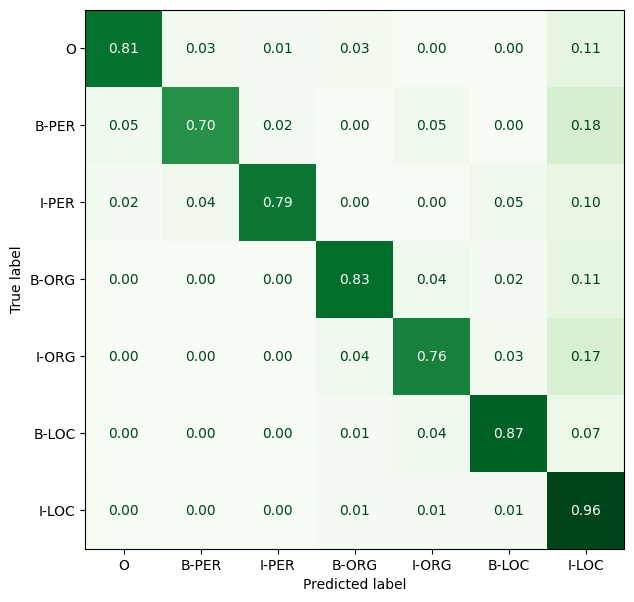

In [16]:
import torch
from transformers import AutoConfig, AutoTokenizer, DataCollatorForTokenClassification
from transformers.models.roberta.modeling_roberta import RobertaForTokenClassification
from itertools import chain
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# generate config
tags = ds["test"].features["ner_tags"].feature
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

# load model
xlmr_config = AutoConfig.from_pretrained(
    "xlm-roberta-base",
    num_labels=tags.num_classes,
    id2label=index2tag,
    label2id=tag2index
)
model = (RobertaForTokenClassification
         .from_pretrained("./hf_finetune_outputs/artifacts/outputs/fintuned_ner_classifier_jp", config=xlmr_config)
         .to(device))

# create data collator
xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
data_collator = DataCollatorForTokenClassification(
    xlmr_tokenizer,
    return_tensors="pt")

# define analyzing function
def process_test(batch):
    # process data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    new_batch = data_collator(features)
    # run inference (prediction)
    with torch.no_grad():
        input_ids = new_batch["input_ids"].to(device)
        attention_mask = new_batch["attention_mask"].to(device)
        output = model(input_ids, attention_mask)
        predicted_label_id = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # compute loss (but we won't use this result)
    true_label_id = new_batch["labels"].to(device)
    loss = torch.nn.functional.cross_entropy(
        output.logits.view(-1, tags.num_classes),
        true_label_id.view(-1),
        reduction="none"
    )
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    # create output
    return {
        "loss": loss,
        "predicted_labels": predicted_label_id
    }

# run analysis (with test data)
test_ds = tokenized_ds["test"]
test_output = test_ds.map(process_test, batched=True, batch_size=32)
test_output_df = test_output.to_pandas()
test_output_df["label_tags"] = test_output_df["labels"].apply(
    lambda row: [index2tag[i] for i in row])
test_output_df["predicted_label_tags"] = test_output_df[["predicted_labels", "attention_mask"]].apply(
    lambda row: [index2tag[i] for i in row.predicted_labels][:len(row.attention_mask)], axis = 1)

# output test result (confusion matrix)
conf_matrix = confusion_matrix(
    list(chain.from_iterable(test_output_df["label_tags"])),
    list(chain.from_iterable(test_output_df["predicted_label_tags"])),
    normalize="true")
fig, ax = plt.subplots(figsize=(7, 7))
conf_display = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=tags.names)
conf_display.plot(cmap="Greens", values_format=".2f", ax=ax, colorbar=False)
plt.show()

## 4. Clean-up (Remove cluster)

In [ ]:
!az ml compute delete --name cluster01 \
  --resource-group $my_resource_group \
  --workspace-name $my_workspace \
  --yes